# TP 7

## Diffraction de rayons X par une surface cristalline

Joseph TOUZET

### Étude numérique 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

on definie un fonction densite(x,n,a,sigma) retournant $\rho$

In [2]:
def densite(x, n, a, sigma):
    #on cree une liste de xj
    xj = np.arange(0, n) * a
    
    #on cree ensuite un tableau x de dimention (len(x), n)
    x_sum = np.repeat(np.expand_dims(x, 1), n, 1)
    
    #on cree une liste des point à sommer
    d_list = np.exp(-(x_sum - xj)**2 / (2 * sigma * sigma))
    
    #et on retourne la somme selon le second axe
    return 1/(sigma * np.sqrt(2 * np.pi))*np.sum(d_list, axis=1)

On definie ensuite la fonction DSPID(x, f)

In [3]:
def DSPID(x, f, args={}):
    #caclul du module carre de la fft normalisé 
    f_tild = np.fft.fftshift(np.fft.fft(f(x, *args)))
    f_tild_module = np.abs(f_tild)**2
    f_tild_normal = f_tild_module / np.max(f_tild_module)
    
    #calcul des frequences
    n, step = len(x), x[1] - x[0]
    freq = np.fft.fftshift(np.fft.fftfreq(n, step))
    
    return f_tild_normal, freq

Puis on la test avec un sinus

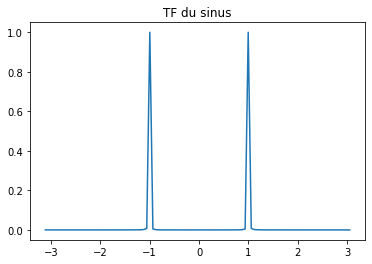

In [4]:
fft_sin, freq = DSPID(np.linspace(0, 100, 100), np.sin)
plt.plot(freq * 2 * np.pi, fft_sin)
plt.title("TF du sinus")
plt.show()

On obtient bien le resultat attendu.

On va dabord definir une fonction retournant la TF analytique.

In [5]:
def I(q, n, a, sigma):
    # on caclul le diviseur
    diviseur = np.sin(q*a/2)**2
    
    #pour eviter une / par 0 on le met egale à 1 la ou il est nul
    #car le dividande est nul quand le diviseur est nul
    diviseur += diviseur == 0
    
    TF = np.exp(-q*q*sigma*sigma) * np.sin(q*n*a/2)**2 / diviseur
    return TF / np.max(TF)

On peut ensuite la comparer à la TF de la fonction analytique.

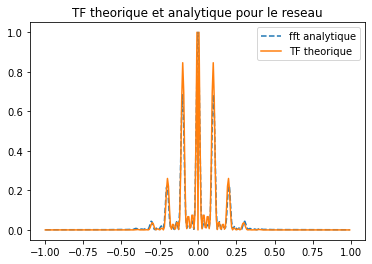

In [6]:
fft_rho, freq = DSPID(np.linspace(0, 150, 300), densite, (4, 10, 1))
plt.plot(freq, fft_rho, "--", label="fft analytique")

tf_rho = I(freq * np.pi * 2, 4, 10, 1)
plt.plot(freq, tf_rho, label="TF theorique")

plt.legend()
plt.title("TF theorique et analytique pour le reseau")
plt.show()

### Intensité 2D diffusée par un unique atome et un réseau

On definie dabord la fonction DSP2D(x, y, z).

In [88]:
def DSP2D(x, y, z):
    #caclul du module carre de la fft normalisé 
    f_tild = np.fft.fftshift(np.fft.fft2(z))
    f_tild_module = np.abs(f_tild)**2
    f_tild_normal = f_tild_module / np.max(f_tild_module)
    
    #calcul des frequences sur x et y
    n_x, step_x = x.shape[0], x[0, 1] - x[0, 0]
    n_y, step_y = y.shape[1], y[1, 0] - y[0, 0]
    freq_x = np.fft.fftshift(np.fft.fftfreq(n_x, step_x)) * np.pi * 2
    freq_y = np.fft.fftshift(np.fft.fftfreq(n_y, step_y)) * np.pi * 2
    
    #meshgrid
    freq_x_mesh, freq_y_mesh = np.meshgrid(freq_x, freq_y)
    
    return f_tild_normal, freq_x_mesh, freq_y_mesh

On test ensuite cette fonction avec une gaussienne.

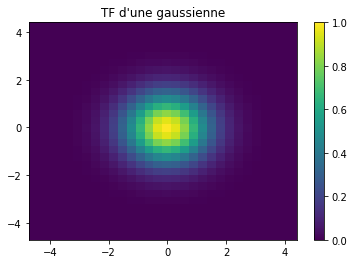

In [89]:
def gauss(x, y):
    return np.exp(-(x**2 + y**2))

x, y = np.linspace(-10, 10, 30), np.linspace(-10, 10, 30)
X, Y = np.meshgrid(x, y)
fft, freq_x, freq_y = DSP2D(X, Y, gauss(X, Y))

plt.pcolormesh(freq_x, freq_y, fft, shading='auto')
plt.colorbar()
plt.title("TF d'une gaussienne")
plt.show()

On a bien le resultat attendu (la TF d'une gaussienne est une gaussienne).

On peut maintenant definir la fonction reseaul(m, a)

In [90]:
def reseaul(m, a):
    xj = np.arange(0, m) * a
    yj = np.arange(0, m) * a
    
    x_mesh, y_mesh = np.meshgrid(xj, yj)
    return x_mesh.flatten(), y_mesh.flatten()

Puis la fonction reseau_carre(x, y, xat, yat, sigma)

In [91]:
def reseau_carre(x, y, xat, yat, sigma):
    #on cree ensuite des tableau de x_sum et y_sum de dimention (.., len(xat))
    x_sum = np.repeat(np.expand_dims(x, 2), len(xat), 2)
    y_sum = np.repeat(np.expand_dims(y, 2), len(yat), 2)
    
    #on cree une liste des point à sommer
    d_list = np.exp(-((x_sum - xat)**2 + (y_sum - yat)**2) / (2 * sigma * sigma))

    #et on retourne la somme selon le second axe
    return 1/(sigma * np.sqrt(2 * np.pi))*np.sum(d_list, axis=2)

On trace ici la repartition de charge pour $ a=5A $, $ \sigma=0.4A $ et un reseau 4x4 et donc $m=4$.

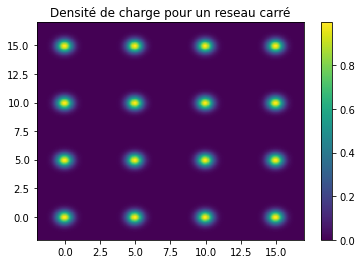

In [92]:
xat, yat = reseaul(4, 5)

x, y = np.linspace(-2, 17, 500), np.linspace(-2, 17, 500)
X, Y = np.meshgrid(x, y)

z = reseau_carre(X, Y, xat, yat, 0.4)

plt.pcolormesh(X, Y, z, shading='auto')
plt.colorbar()
plt.title("Densité de charge pour un reseau carré")
plt.show()

On trace maintenant la fft spaciale pour meusurer le parametre de maille.

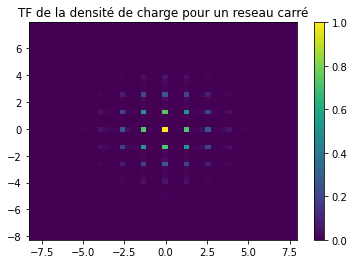

In [93]:
x, y = np.linspace(-2, 17, 50), np.linspace(-2, 17, 50)
X, Y = np.meshgrid(x, y)
z = reseau_carre(X, Y, xat, yat, 0.4)

fft, freq_x, freq_y = DSP2D(X, Y, z)

plt.pcolormesh(freq_x, freq_y, fft, shading='auto')
plt.colorbar()
plt.title("TF de la densité de charge pour un reseau carré")
plt.show()

On meusure des maximum de la TF aux coordonées $ (n*0.2, m*0.2) $ ce qui donne une frequence spatial de $ k = 0.2 A^{-1} $ et donc $ a = 1/k = 5A $ ce qui est coherent avec le parametre rentré dans reseaul(m, a).

On creer maintenant une fonction reseau_centre(m, a) analogue à reseaul(m, a) qui crer un reseau carré centré.

On rajoutera un parametre optionel offset qui deplacera l'atome (pour la question 12).

In [94]:
def reseau_centre(m, a, offset=0.5):
    x_1, y_1 = reseaul(m, a)
    x_2, y_2 = reseaul(m - 1, a)
    
    x = np.concatenate((x_1, x_2 + a*offset))
    y = np.concatenate((y_1, y_2 + a*offset))
    
    return x, y

On trace maintenant la repartition de charge pour $ a=5A $, $ \sigma=0.4A $ et un reseau carré centré 4x4 et donc $m=4$.

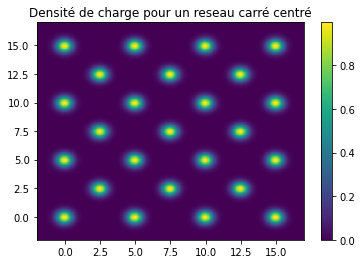

In [95]:
xat, yat = reseau_centre(4, 5)

x, y = np.linspace(-2, 17, 500), np.linspace(-2, 17, 500)
X, Y = np.meshgrid(x, y)

z = reseau_carre(X, Y, xat, yat, 0.4)

plt.pcolormesh(X, Y, z, shading='auto')
plt.colorbar()
plt.title("Densité de charge pour un reseau carré centré")
plt.show()

On trace maintenant la fft spaciale pour meusurer le parametre de maille.

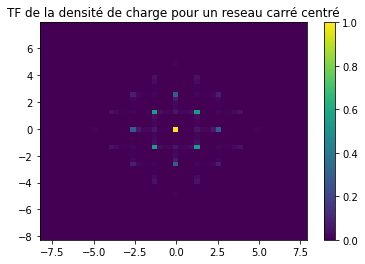

In [96]:
x, y = np.linspace(-2, 17, 50), np.linspace(-2, 17, 50)
X, Y = np.meshgrid(x, y)
z = reseau_carre(X, Y, xat, yat, 0.4)

fft, freq_x, freq_y = DSP2D(X, Y, z)

plt.pcolormesh(freq_x, freq_y, fft, shading='auto')
plt.colorbar()
plt.title("TF de la densité de charge pour un reseau carré centré")
plt.show()

On obtient le meme resultat que precedement en terme de parametre de maille.

Cependant la figure a maintenant de nouveau axe de repetition (45° et 90° contre seulement 90° pour le reseau precedent).

On fait maintenant les meme calcul pour 

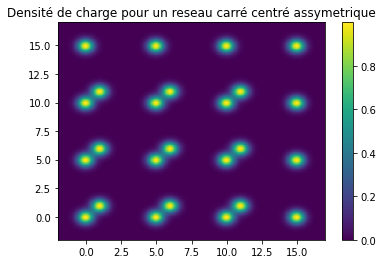

In [97]:
xat, yat = reseau_centre(4, 5, 0.2)

x, y = np.linspace(-2, 17, 500), np.linspace(-2, 17, 500)
X, Y = np.meshgrid(x, y)

z = reseau_carre(X, Y, xat, yat, 0.4)

plt.pcolormesh(X, Y, z, shading='auto')
plt.colorbar()
plt.title("Densité de charge pour un reseau carré centré assymetrique")
plt.show()

On trace ensuite la fft spaciale.

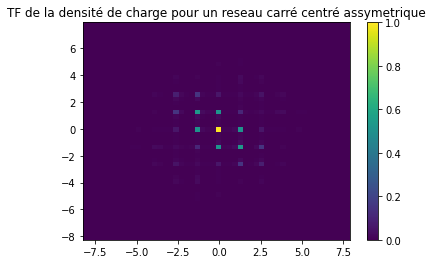

In [98]:
x, y = np.linspace(-2, 17, 50), np.linspace(-2, 17, 50)
X, Y = np.meshgrid(x, y)
z = reseau_carre(X, Y, xat, yat, 0.4)

fft, freq_x, freq_y = DSP2D(X, Y, z)

plt.pcolormesh(freq_x, freq_y, fft, shading='auto')
plt.colorbar()
plt.title("TF de la densité de charge pour un reseau carré centré assymetrique")
plt.show()

On remarque que la fft prend la meme assymetrie que le reseau.

### Analyse de données expérimentales

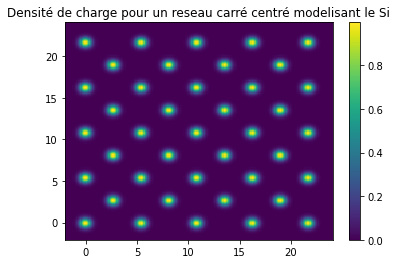

In [105]:
a = 5.43
n = 5

xat, yat = reseau_centre(n, a)

x, y = np.linspace(-2, 24, 200), np.linspace(-2, 24, 200)
X, Y = np.meshgrid(x, y)
z = reseau_carre(X, Y, xat, yat, 0.4)

plt.pcolormesh(X, Y, z, shading='auto')
plt.colorbar()
plt.title("Densité de charge pour un reseau carré centré modelisant le Si")
plt.show()

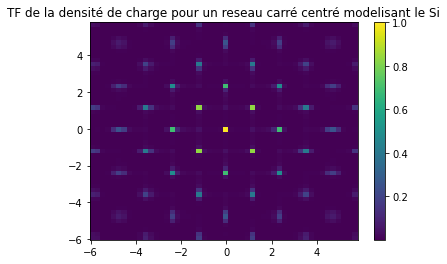

In [106]:
x, y = np.linspace(-2, 24, 50), np.linspace(-2, 24, 50)
X, Y = np.meshgrid(x, y)
z = reseau_carre(X, Y, xat, yat, 0.2)

fft, freq_x, freq_y = DSP2D(X, Y, z)

plt.pcolormesh(freq_x, freq_y, fft, shading='auto')
plt.colorbar()
plt.title("TF de la densité de charge pour un reseau carré centré modelisant le Si")
plt.show()

Le resultat que l'on obtient est comparable à celui de la figure 5.

Sur la figure 5 on meusure une frequence spaciale (entre 2 pics) d'environ $ 2A^{-1} $, et en prenant $ a = 5.43 A $ on trouve aussi une frequence spaciale de $ 2 A^{-1} $.